In [170]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import glob
import statsmodels.api as sm
from statsmodels.stats import outliers_influence
import matplotlib.pyplot as plt

import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

%matplotlib inline

In [171]:
class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

# Load data

In [172]:
data = pd.read_csv('./../data/interim_data/AHEAD_and_CRUISE-wide-combined.csv', index_col=0)
mgdm = pd.read_csv('./../data/MGDM_combined_qpdcorrected.csv', index_col=0)

In [173]:
# Cast all columns except Measure, Intensity, Segmentation to float
structs = []
for col in data.columns:
    if col in ['Measure', 'Intensity', 'Segmentation', 'Age', 'Sexe']:
        continue
    data[col] = data[col].astype(float)
    structs.append(col)
    
# Melt
data_melted = data.melt(id_vars=['Intensity', 'Measure', "Segmentation", 'Age', 'Sexe'],
                        value_vars=structs, value_name='Value', var_name='ROI')
data_melted['ROI2'] = data_melted['ROI'].str.split(' ').apply(lambda x: x[0])
data_melted.loc[data_melted.ROI.isin(['3V', '4V']), 'ROI2'] = 'LV'
data_melted['hemisphere'] = data_melted['ROI'].str.split(' ').apply(lambda x: x[1] if len(x)>1 else 'X')
data_melted['tissue_type'] = data_melted['ROI2'].map({'STR': 'GM',
                                                      'STN': 'GM',
                                                      'SN': 'GM',
                                                      'RN': 'GM',
                                                      'GPi': 'GM',
                                                      'GPe': 'GM',
                                                      'THA': 'GM',
                                                      'LV': 'CSF',
                                                      '3V': 'CSF',
                                                      '4V': 'CSF',
                                                      'AMG': 'GM',
                                                      'ic': 'WM',
                                                      'VTA': 'GM',
                                                      'fx': 'WM',
                                                      'PAG': 'GM',
                                                      'PPN': 'GM',
                                                      'ICO': 'GM',
                                                      'SCO': 'GM',
                                                      'CL': 'GM',
                                                      'Cortex': 'GM',
                                                      'Cerebellum': 'GM'})
data_melted.head()

,Intensity,Measure,Segmentation,Age,Sexe,ROI,Value,ROI2,hemisphere,tissue_type
0,qpd,IQR_intensity,sub-000,22.0,f,STR L,0.214799,STR,L,GM
1,qsm,IQR_intensity,sub-000,22.0,f,STR L,0.026030,STR,L,GM
2,r1hz,IQR_intensity,sub-000,22.0,f,STR L,0.077003,STR,L,GM
3,r2hz,IQR_intensity,sub-000,22.0,f,STR L,11.515187,STR,L,GM
4,qpd,IQR_intensity,sub-001,23.0,m,STR L,0.181362,STR,L,GM


### Pivot back

In [174]:
data_median = data_melted.loc[(data_melted['Measure'] == 'Median_intensity') & (data_melted['Intensity'].isin(['qsm', 'r1hz', 'r2hz']))]
data_median = data_median.pivot_table(values='Value', columns='Intensity', index=['Segmentation', 'ROI', 'ROI2', 'Age'])
data_median

Intensity                          qsm      r1hz       r2hz
Segmentation ROI   ROI2 Age                                
sub-000      3V    LV   22.0  0.006497  0.305915   5.459753
             4V    LV   22.0  0.009121  0.262851   6.040544
             AMG L AMG  22.0 -0.006271  0.521128  21.830616
             AMG R AMG  22.0 -0.004227  0.550649  21.108710
             CL L  CL   22.0 -0.012107  0.618375  30.173168
...                                ...       ...        ...
sub-109      VTA L VTA  23.0 -0.004336  0.791675  33.231804
             VTA R VTA  23.0 -0.003958  0.817702  35.548073
             fx    fx   23.0 -0.004810  0.739041  29.147950
             ic L  ic   23.0 -0.018271  0.884558  33.914547
             ic R  ic   23.0 -0.017752  0.881065  33.962044

[3570 rows x 3 columns]

## Get quantified iron and myelin measures

In [175]:
## From Hallgren, 1958
iron_measures = pd.Series({'RN': 19.48,
                           'SN': 18.46,
                           'GPi': 21.30,
                           'GPe': 21.30,
                           'THA': 4.76,
                           'PUT': 13.32,
                           'CAU': 9.28,
                           'Cerebellum': 3.35,
                           'Frontal Cortex': 2.92,
                           'Temporal Cortex': 3.13,
                           'Parietal Cortex': 3.81,
                           'Sensory Cortex': 4.32,
                           'Occipital Cortex': 4.55,
                           'Motor Cortex': 5.03,
                           'LV': 0.062,      # CSF measures NOT from Hallgren, but from Metere et al. (2018)
                           'Frontal White': 4.24,
                           'Brainstem': 1.40}, name='iron')
iron_measures_sd = pd.Series({'RN': 6.86,
                           'SN': 6.52,
                           'GPi': 3.49,
                           'GPe': 3.49,
                           'THA': 1.16,
                           'PUT': 3.43,
                           'CAU': 2.14,
                           'Cerebellum': 0.87,
                           'Frontal Cortex': 0.41,
                           'Temporal Cortex': 0.57,
                           'Parietal Cortex': 0.67,
                           'Sensory Cortex': 0.58,
                           'Occipital Cortex': 0.67,
                           'Motor Cortex': 0.88,
                           #'LV': 0.062,      # CSF measures NOT from Hallgren, but from Metere et al. (2018)
                           'Frontal White': 0.88,
                           'Brainstem': 1.16}, name='iron')

## From Randall, 1938
myelin_measures = pd.Series({'CAU': 6.21,
                             'LV': 0.0025,   # CSF meaures NOT from Randall, but from Metere et al. (2018)
                             'Frontal Cortex': 5.08,
                             'Parietal Cortex': 5.42,
                             'THA': 11.40,
                             'Frontal White': 16.26,
                             'Parietal White': 17.20,
                             'Brainstem': 15.36}, name='myelin')

myelin_measures_sd = pd.Series({'CAU': 2.43,
                             #'LV': 0.0025,   # CSF meaures NOT from Randall, but from Metere et al. (2018)
                             'Frontal Cortex': 1.48,
                             'Parietal Cortex': 1.15,
                             'THA': 1.93,
                             'Frontal White': 2.48,
                             'Parietal White': 1.68,
                             'Brainstem': 1.58}, name='myelin')


# not used..
water_measures = pd.Series({'Corona Radiata': 69.83,
                            'Frontal White': 70.64,
                            'Parietal White': 69.92,
                            'Brain stem': 71.67,
                            'THA': 75.79,
                            'CAU': 81.43,
                            'Frontal Cortex': 84.12,
                            'Parietal Cortex': 83.46,
                            'Brainstem': 71.67}, name='water')

## Myelin measures from stain

Plot the relation between stain intensity (x-axis) and myelin content (y-axis, from literature). Do this per slice separately to prevent a confounding influence from overall slice intensity differences

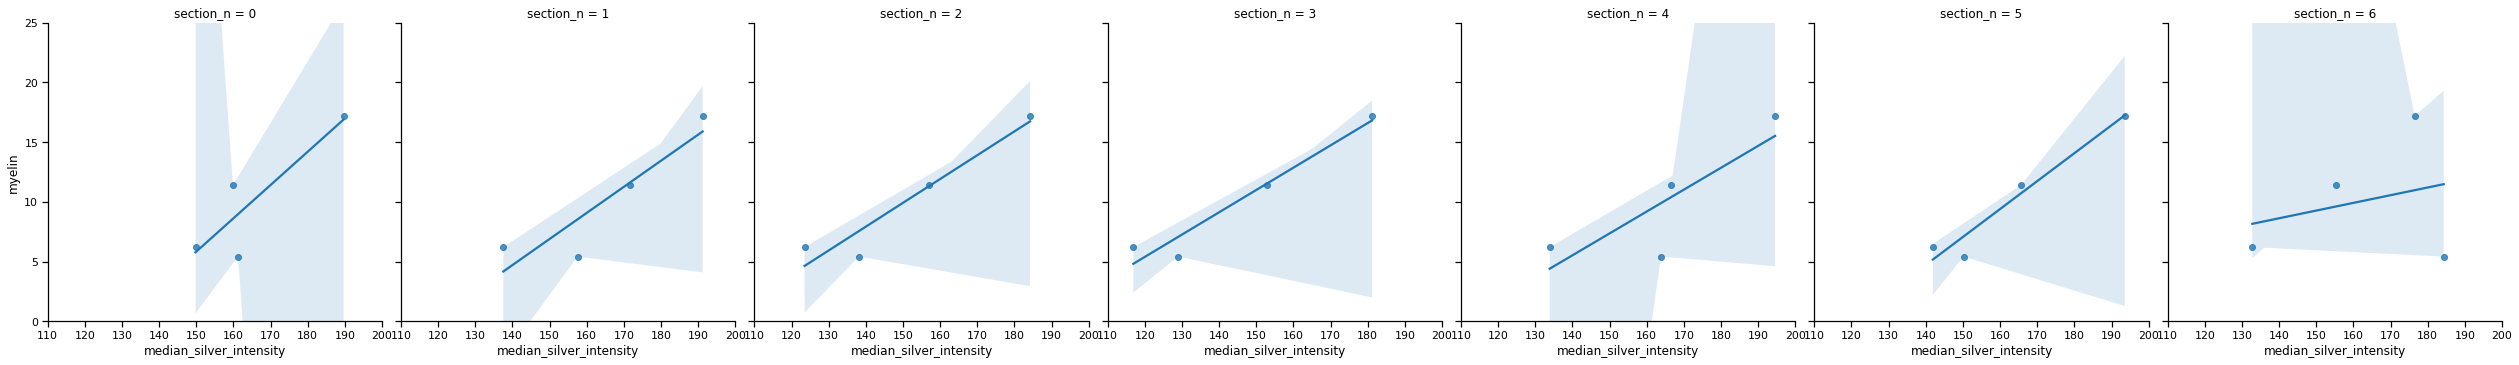

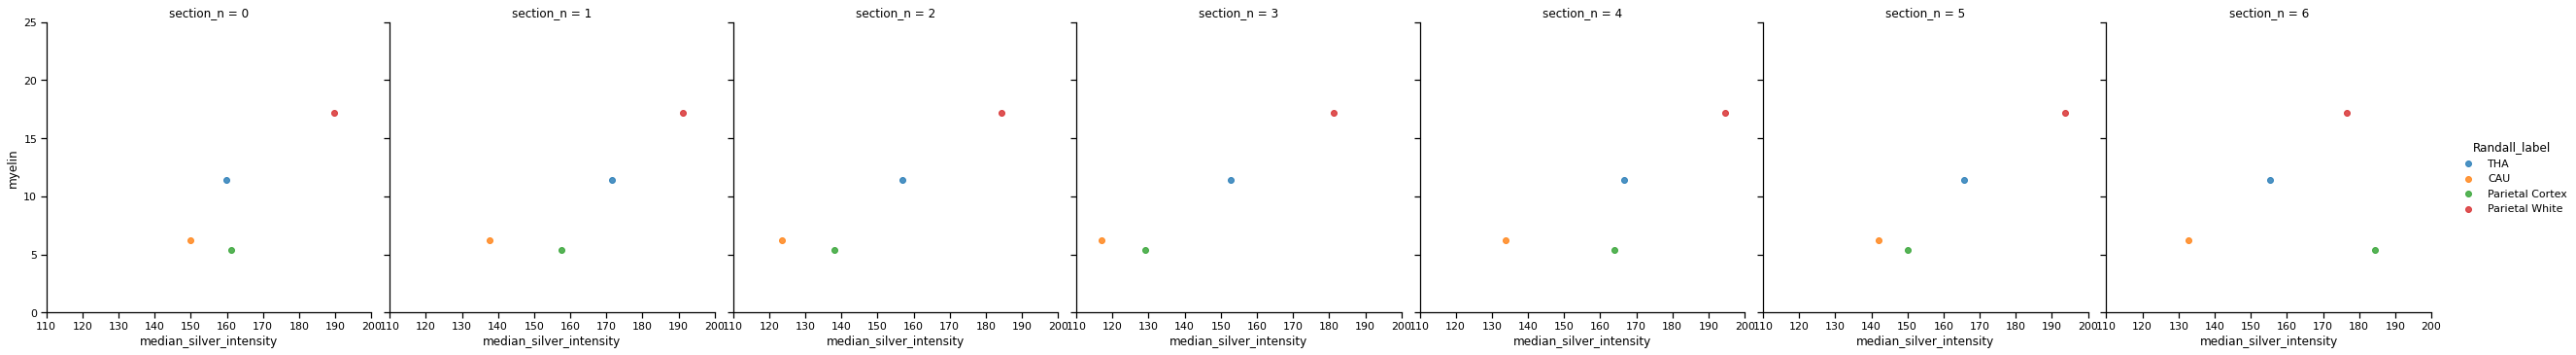

In [176]:
silver_stain_intensities = pd.read_csv('../data/silver-stains-intensity-samples.csv')
silver_stain_intensities = silver_stain_intensities.loc[silver_stain_intensities.Measure == 'Median_intensity'].reset_index(drop=True)
silver_stain_intensities['section_name'] = silver_stain_intensities['Segmentation'].apply(lambda x: x.split('_')[5].split('-')[0])
silver_stain_intensities.index.name = 'section_n'
del silver_stain_intensities['Template']
del silver_stain_intensities['Intensity']

silver_stain_intensities = silver_stain_intensities.reset_index().melt(id_vars=['section_n', 'section_name', 'Measure'], 
                                                                       value_vars=['Put', 'GP', 'Tha', 'Cau', 'STN', 'Ctx', 'wm', 'RN', 'SN'], 
                                                                       var_name='ROI', 
                                                                       value_name='median_silver_intensity')
silver_stain_intensities.ROI = silver_stain_intensities.ROI.replace({'Put': 'PUT', 'Tha': 'THA', 'Cau': 'CAU'})

# Mark corresponding labels from Randall
silver_stain_intensities['Randall_label'] = list(silver_stain_intensities['ROI'].map({'CAU': 'CAU', 
                                                                                      'Ctx': 'Parietal Cortex', 
                                                                                      'GP': 'GP', 
                                                                                      'PUT': 'PUT', 
                                                                                      'RN': 'RN', 
                                                                                      'STN': 'STN', 
                                                                                      'THA': 'THA', 
                                                                                      'wm': 'Parietal White', 
                                                                                      'SN': 'SN'}))

# Compare myelin estimates from Randall (1958) with silver stain intensities in 7 sections
structs_in_slice_with_known_myelin = pd.merge(silver_stain_intensities, myelin_measures, left_on='Randall_label', right_index=True)
sns.set_context('notebook')
g = sns.lmplot(data=structs_in_slice_with_known_myelin.reset_index(), x='median_silver_intensity', y='myelin', #hue='Randall_label', 
               col='section_n', col_wrap=7)
g.set(ylim=(0, 25), xlim=(110, 200))

g = sns.lmplot(data=structs_in_slice_with_known_myelin.reset_index(), x='median_silver_intensity', y='myelin', hue='Randall_label', 
               col='section_n', col_wrap=7)
g.set(ylim=(0, 25), xlim=(110, 200))

## Estimate all myelin concentrations in structures on section

Slice 0: myelin = -35.990 + 0.279*intensity
Slice 1: myelin = -25.883 + 0.219*intensity
Slice 2: myelin = -19.996 + 0.199*intensity
Slice 3: myelin = -17.020 + 0.187*intensity
Slice 4: myelin = -20.136 + 0.183*intensity
Slice 5: myelin = -28.000 + 0.234*intensity
Slice 6: myelin = -0.392 + 0.064*intensity


section_n,0,1,2,3,4,5,6
ROI,,,,,,,
CAU,5.779071,4.170891,4.634464,4.814158,4.402147,5.168983,8.161727
Ctx,8.971930,8.542381,7.559753,7.067494,9.898938,7.103477,11.481174
GP,6.736931,11.970029,9.899987,10.404170,11.717110,11.861285,8.722344
PUT,1.436793,5.611496,5.039504,6.634160,5.332372,6.423789,7.763394
RN,13.441928,NaN,NaN,NaN,13.070166,14.893732,NaN
SN,1.181362,9.784283,9.179915,8.280830,7.404243,6.476076,7.335554
STN,14.016642,15.596377,15.615550,15.907512,13.450714,14.423179,8.604319
THA,8.588787,11.622295,11.295122,11.530837,10.406334,10.711045,9.607530
wm,16.890212,15.894433,16.740662,16.817511,15.522580,17.246496,10.979568


ROI
CAU     5.304491
Ctx     8.660735
GP     10.187408
PUT     5.463073
RN     13.801942
SN      7.091752
STN    13.944899
THA    10.537421
wm     15.727352
dtype: float64

<AxesSubplot:xlabel='ROI', ylabel='predicted_myelin'>

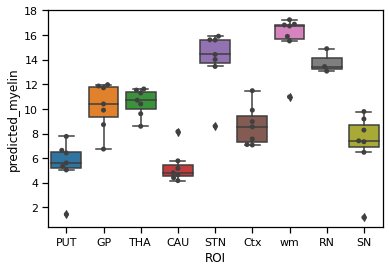

In [177]:
silver_stain_intensities['predicted_myelin'] = np.nan

for section_n in np.arange(7):
    this_data = structs_in_slice_with_known_myelin.loc[structs_in_slice_with_known_myelin.section_n==section_n].copy()
    mod1 = sm.OLS(this_data['myelin'], sm.add_constant(this_data['median_silver_intensity']))
    res = mod1.fit()
    print('Slice {}: myelin = {:.3f} + {:.3f}*intensity'.format(section_n, res.params[0], res.params[1]))
    
    # use model to predict all myelin contents
    idx = silver_stain_intensities.section_n == section_n
    silver_stain_intensities.loc[idx,'predicted_myelin'] = res.params['const'] + silver_stain_intensities.loc[idx, 'median_silver_intensity']*res.params['median_silver_intensity']

# predicted myelin per slice
display(silver_stain_intensities.pivot_table(values='predicted_myelin', index='ROI', columns='section_n'))
display(silver_stain_intensities.pivot_table(values='predicted_myelin', index='ROI', columns='section_n').mean(1))
sns.boxplot(data=silver_stain_intensities, y='predicted_myelin', x='ROI')
sns.swarmplot(data=silver_stain_intensities, y='predicted_myelin', x='ROI', color=".25")

## Figure for paper

Slice 0: myelin = -35.990 + 0.279*intensity
Slice 1: myelin = -25.883 + 0.219*intensity
Slice 2: myelin = -19.996 + 0.199*intensity
Slice 3: myelin = -17.020 + 0.187*intensity


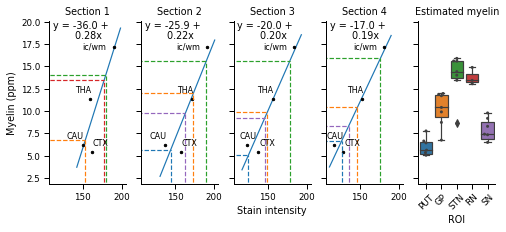

In [178]:
# sns.set_context('paper')
# f, ax = plt.subplots(1,5, figsize=(8,3), sharey=True, sharex=True)

# for section_n in [0,1,2,3]:
#     # plot line
#     this_data = structs_in_slice_with_known_myelin.loc[structs_in_slice_with_known_myelin.section_n==section_n].copy()
#     mod1 = sm.OLS(this_data['myelin'], sm.add_constant(this_data['median_silver_intensity']))
#     res = mod1.fit()
#     print('Slice {}: myelin = {:.3f} + {:.3f}*intensity'.format(section_n, res.params[0], res.params[1]))

#     xs = np.arange(this_data.median_silver_intensity.min()*.95, this_data.median_silver_intensity.max()*1.05)
#     ax[section_n].plot(xs, res.predict(sm.add_constant(xs)))
    
#     for roi in ['THA', 'CAU', 'Parietal Cortex', 'Parietal White']:
#         idx = (structs_in_slice_with_known_myelin.section_n==section_n) & (structs_in_slice_with_known_myelin.Randall_label==roi)
#         x = structs_in_slice_with_known_myelin.loc[idx, 'median_silver_intensity'].values
#         y = structs_in_slice_with_known_myelin.loc[idx, 'myelin'].values
#         ax[section_n].plot(x, y, '.', color='black')
        
#         label = roi.replace('Parietal ', '').replace('Cortex', 'CTX')
#         if label == 'White':
#             label = 'ic/wm'
#             x -= 10
#             verticalalignment='top'
#         else:
#             verticalalignment='bottom'
#         if label in ['THA', 'ic/wm', 'CAU']:
#             horizontalalignment = 'right'
#         else:
#             horizontalalignment = 'left'
#         if section_n in [2,3] and label == 'CAU':
#             horizontalalignment='center'
#         ax[section_n].text(x+1, y+0.5, label, horizontalalignment=horizontalalignment, verticalalignment=verticalalignment, fontsize=8)
            
#     # prettiert
#     ax[section_n].set_title(f'Section {section_n+1}')
#     ax[section_n].text(0.05, 1, r'y = {:.1f} +'.format(res.params[0]),
#                      horizontalalignment='left',
#                      verticalalignment='top', transform = ax[section_n].transAxes)
#     ax[section_n].text(0.3, .94, r' {:.2f}x'.format(res.params[1]),
#                      horizontalalignment='left',
#                      verticalalignment='top', transform = ax[section_n].transAxes)
    
# ax[2].set_xlabel('Stain intensity')
# ax[0].set_ylabel('Myelin (ppm)')

# cols = {'GP': sns.color_palette()[1], 
#         'RN': sns.color_palette()[3],
#         'STN': sns.color_palette()[2],
#         'SN': sns.color_palette()[4],
#         'PUT': sns.color_palette()[0]}

# for section_n in [0,1,2,3]:
#     for roi in ['GP', 'STN', 'RN', 'SN', 'PUT']:
#         x = silver_stain_intensities.loc[(silver_stain_intensities.section_n==section_n) & (silver_stain_intensities.ROI==roi), 'median_silver_intensity'].values
#         y = silver_stain_intensities.loc[(silver_stain_intensities.section_n==section_n) & (silver_stain_intensities.ROI==roi), 'predicted_myelin'].values
#         # get limits
#         xlim = ax[section_n].get_xlim()
#         ylim = ax[section_n].get_ylim()
#         ax[section_n].plot([x, x], [-4, y], '--', color=cols[roi])
#         ax[section_n].plot([-4, x], [y, y], '--', color=cols[roi])
#         ax[section_n].set_xlim(xlim)
#         ax[section_n].set_ylim(ylim)

# ax[-1].axis('off')

# ax5 = f.add_subplot(1, 5, 5)
# sns.boxplot(data=silver_stain_intensities.loc[silver_stain_intensities.ROI.isin(['PUT', 'GP', 'STN', 'SN', 'RN'])], y='predicted_myelin', x='ROI', ax=ax5)
# sns.swarmplot(data=silver_stain_intensities.loc[silver_stain_intensities.ROI.isin(['PUT', 'GP', 'STN', 'SN', 'RN'])], y='predicted_myelin', x='ROI', color=".25", size=3, ax=ax5)
# ax5.set_title('Estimated myelin')
# ax5.set_xticklabels(['PUT', 'GP', 'STN', 'RN', 'SN'], rotation=45)
# ax5.set_yticklabels([])
# ax5.set_ylim(ax[0].get_ylim())
# ax5.set_ylabel('')

# sns.despine()
# f.savefig('../figures/original_submission/figure6.pdf', bbox_inches='tight')

Slice 0: myelin = -35.990 + 0.279*intensity
Slice 1: myelin = -25.883 + 0.219*intensity
Slice 2: myelin = -19.996 + 0.199*intensity
Slice 3: myelin = -17.020 + 0.187*intensity
Slice 4: myelin = -20.136 + 0.183*intensity
Slice 5: myelin = -28.000 + 0.234*intensity
Slice 6: myelin = -0.392 + 0.064*intensity


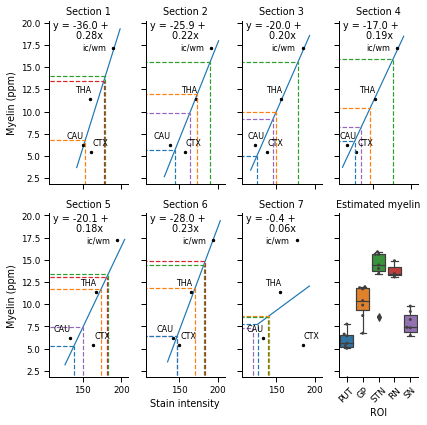

In [180]:
sns.set_context('paper')
f, ax = plt.subplots(2,4, figsize=(6,6), sharey=True, sharex=True)
plt.ylabel('Myelin (ppm)')

ax = ax.ravel()

for section_n in [0,1,2,3,4,5,6]:
    # plot line
    this_data = structs_in_slice_with_known_myelin.loc[structs_in_slice_with_known_myelin.section_n==section_n].copy()
    mod1 = sm.OLS(this_data['myelin'], sm.add_constant(this_data['median_silver_intensity']))
    res = mod1.fit()
    print('Slice {}: myelin = {:.3f} + {:.3f}*intensity'.format(section_n, res.params[0], res.params[1]))

    xs = np.arange(this_data.median_silver_intensity.min()*.95, this_data.median_silver_intensity.max()*1.05)
    ax[section_n].plot(xs, res.predict(sm.add_constant(xs)))
    
    for roi in ['THA', 'CAU', 'Parietal Cortex', 'Parietal White']:
        idx = (structs_in_slice_with_known_myelin.section_n==section_n) & (structs_in_slice_with_known_myelin.Randall_label==roi)
        x = structs_in_slice_with_known_myelin.loc[idx, 'median_silver_intensity'].values
        y = structs_in_slice_with_known_myelin.loc[idx, 'myelin'].values
        ax[section_n].plot(x, y, '.', color='black')
        
        label = roi.replace('Parietal ', '').replace('Cortex', 'CTX')
        if label == 'White':
            label = 'ic/wm'
            x -= 10
            verticalalignment='top'
        else:
            verticalalignment='bottom'
        if label in ['THA', 'ic/wm', 'CAU']:
            horizontalalignment = 'right'
        else:
            horizontalalignment = 'left'
        if section_n in [2,3] and label == 'CAU':
            horizontalalignment='center'
        ax[section_n].text(x+1, y+0.5, label, horizontalalignment=horizontalalignment, verticalalignment=verticalalignment, fontsize=8)
            
    # prettiert
    ax[section_n].set_title(f'Section {section_n+1}')
    ax[section_n].text(0.05, 1, r'y = {:.1f} +'.format(res.params[0]),
                     horizontalalignment='left',
                     verticalalignment='top', transform = ax[section_n].transAxes)
    ax[section_n].text(0.3, .94, r' {:.2f}x'.format(res.params[1]),
                     horizontalalignment='left',
                     verticalalignment='top', transform = ax[section_n].transAxes)
    

cols = {'GP': sns.color_palette()[1], 
        'RN': sns.color_palette()[3],
        'STN': sns.color_palette()[2],
        'SN': sns.color_palette()[4],
        'PUT': sns.color_palette()[0]}

for section_n in [0,1,2,3,4,5,6]:
    for roi in ['GP', 'STN', 'RN', 'SN', 'PUT']:
        x = silver_stain_intensities.loc[(silver_stain_intensities.section_n==section_n) & (silver_stain_intensities.ROI==roi), 'median_silver_intensity'].values
        y = silver_stain_intensities.loc[(silver_stain_intensities.section_n==section_n) & (silver_stain_intensities.ROI==roi), 'predicted_myelin'].values
        # get limits
        xlim = ax[section_n].get_xlim()
        ylim = ax[section_n].get_ylim()
        ax[section_n].plot([x, x], [-4, y], '--', color=cols[roi])
        ax[section_n].plot([-4, x], [y, y], '--', color=cols[roi])
        ax[section_n].set_xlim(xlim)
        ax[section_n].set_ylim(ylim)

ax[-1].axis('off')

ax5 = f.add_subplot(2, 4, 8)
sns.boxplot(data=silver_stain_intensities.loc[silver_stain_intensities.ROI.isin(['PUT', 'GP', 'STN', 'SN', 'RN'])], y='predicted_myelin', x='ROI', ax=ax5)
sns.swarmplot(data=silver_stain_intensities.loc[silver_stain_intensities.ROI.isin(['PUT', 'GP', 'STN', 'SN', 'RN'])], y='predicted_myelin', x='ROI', color=".25", size=3, ax=ax5)
ax5.set_title('Estimated myelin')
ax5.set_xticklabels(['PUT', 'GP', 'STN', 'RN', 'SN'], rotation=45)
ax5.set_yticklabels([])
ax5.set_ylim(ax[0].get_ylim())
ax5.set_ylabel('')


#ax[2].set_xlabel('Stain intensity')
ax[0].set_ylabel('Myelin (ppm)')
ax[4].set_ylabel('Myelin (ppm)')

ax[-3].set_xlabel('Stain intensity')
#ax[1,1].set_xlabel('Stain intensity')
plt.tight_layout()

sns.despine()
f.savefig('../figures/R1/stain_interpolation.pdf', bbox_inches='tight')

### Get final myelin estimates:
- Take Randall value where possible
- Take median of predictions otherwise

In [181]:
average_predicted_myelin = silver_stain_intensities.groupby(['ROI', 'Randall_label']).median().reset_index()
del average_predicted_myelin['section_n']

final_myelin_estimates = pd.merge(average_predicted_myelin, myelin_measures, left_on='Randall_label', right_index=True, how='outer')
final_myelin_estimates['final_myelin_concentration_estimate'] = final_myelin_estimates['myelin'].copy()
final_myelin_estimates.loc[pd.isnull(final_myelin_estimates['final_myelin_concentration_estimate']), 'final_myelin_concentration_estimate'] = final_myelin_estimates.loc[pd.isnull(final_myelin_estimates['final_myelin_concentration_estimate']), 'predicted_myelin']
final_myelin_estimates = final_myelin_estimates.set_index('Randall_label')

# Use GP myelin estimates for both GPe and GPi qMRI values
final_myelin_estimates.loc['GPe', ['ROI', 'ROI','median_silver_intensity','predicted_myelin','myelin','final_myelin_concentration_estimate']] = final_myelin_estimates.loc['GP', ['ROI', 'ROI','median_silver_intensity','predicted_myelin','myelin','final_myelin_concentration_estimate']].copy()
final_myelin_estimates.loc['GPi', ['ROI', 'ROI','median_silver_intensity','predicted_myelin','myelin','final_myelin_concentration_estimate']] = final_myelin_estimates.loc['GP', ['ROI', 'ROI','median_silver_intensity','predicted_myelin','myelin','final_myelin_concentration_estimate']].copy()
final_myelin_estimates

final_myelin_estimates.to_pickle('./all_myelin_estimates.pkl')   ## save for later

# Get corresponding qMRI measures

Hallgren et al. (1958) had subjects in age range of 30 and above. Randall had age range 28-82.

The R1 measure of CSF is not estimated correctly using MP2RAGE (due to R1 > TI), hence we follow Metere's approach and take the R1 value obtained from the literature.

The myelin estimates based on the silver stain are from an elderly subject. For these, we take the average qMRI values of age > 70 (13 participants in total)

In [182]:
data_p30_means = data_median.query('Age >= 30').groupby(level=[0, 2]).mean().groupby(level=[1]).mean()  # get mean of medians
data_p30_means

data_p70_means = data_median.query('Age >= 70').groupby(level=[0, 2]).mean().groupby(level=[1]).mean()  # get mean of medians
data_p70_means

Intensity,qsm,r1hz,r2hz
ROI2,,,
AMG,0.001605,0.561855,27.340812
CL,-0.012083,0.657411,33.792871
Cerebellum,-0.000085,0.501499,34.538948
Cortex,-0.000016,0.536692,33.685530
GPe,0.044293,0.813011,84.874909
GPi,0.046384,0.838298,75.215914
LV,0.004003,0.356815,6.524158
PAG,-0.002053,0.642211,27.723076
PPN,0.000199,0.762940,34.263307


Hallgren et al. report CAU and PUT as separate structures, whereas we only have STR in our database. As our best estimate, we use the STR qMRI-values for both CAU and PUT

Hallgren et al. report a variety of cortical values; we only have one large cortex gray matter segmentation. Similarly, as our best guess, we use our cortical value for all of the different lobes

Finally, Hallgren et al report frontal white matter. We do not have a coritcal white matter segmentation, but we can use the interna capsula and fornix as a different white matter structures instead, as our best guess of the white matter qMRI-values

In [183]:
data_p30_means.loc['CAU'] = data_p30_means.loc['STR']
data_p30_means.loc['PUT'] = data_p30_means.loc['STR']
data_p30_means.loc['Frontal Cortex'] = data_p30_means.loc['Cortex']
data_p30_means.loc['Temporal Cortex'] = data_p30_means.loc['Cortex']
data_p30_means.loc['Parietal Cortex'] = data_p30_means.loc['Cortex']
data_p30_means.loc['Sensory Cortex'] = data_p30_means.loc['Cortex']
data_p30_means.loc['Occipital Cortex'] = data_p30_means.loc['Cortex']
data_p30_means.loc['Motor Cortex'] = data_p30_means.loc['Cortex']
data_p30_means.loc['Frontal White'] = data_p30_means.loc['ic']

## Extract the brain stem measures from the MGDM segmentation
data_p30_means.loc['Brainstem'] = mgdm.query('Age >= 30').groupby(['Measure', 'Intensity'])['Brainstem'].mean()['Median_intensity']

# Model 1: Iron ~ qMRI

,qsm,r1hz,r2hz,iron
ROI,,,,
Brainstem,-0.000486,0.807652,37.959482,1.400
CAU,0.012768,0.655277,48.644107,9.280
Cerebellum,-0.000078,0.504634,34.068728,3.350
Frontal Cortex,-0.000004,0.536607,32.722217,2.920
Frontal White,-0.022469,0.895587,37.179621,4.240
GPe,0.042671,0.848244,85.106998,21.300
GPi,0.047246,0.869559,77.739099,21.300
Motor Cortex,-0.000004,0.536607,32.722217,5.030
Occipital Cortex,-0.000004,0.536607,32.722217,4.550


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


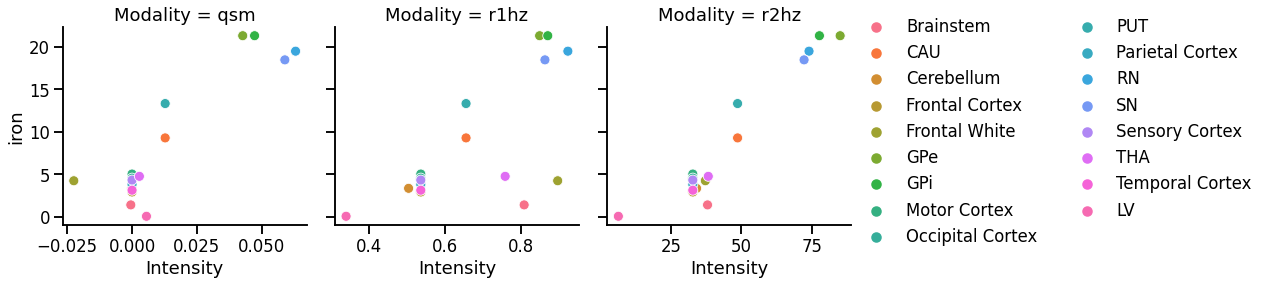

In [184]:
iron_qmri_combined = pd.merge(data_p30_means, iron_measures, left_index=True, right_index=True)
iron_qmri_combined.index.name='ROI'
iron_qmri_combined = iron_qmri_combined.reindex(['Brainstem', 'CAU', 'Cerebellum', 'Frontal Cortex', 'Frontal White', 'GPe', 'GPi', 'Motor Cortex', 'Occipital Cortex', 'PUT', 'Parietal Cortex', 'RN', 'SN', 'Sensory Cortex', 'THA', 'Temporal Cortex', 'LV'])
iron_qmri_combined.round({'qsm': 6, 'r1hz': 3, 'r2hz': 3, 'iron': 3}).rename(columns={'qsm': 'QSM (ppm)', 'r1hz': 'R1 (Hz)', 'r2hz': 'R2* (Hz)', 'iron': 'Iron (ppm)'}).iloc[:,[3,0,1,2]].to_csv('../tables/iron_qmri_table1.csv', sep='\t') ## table 1 in manuscript

iron_qmri_combined_melted = iron_qmri_combined.reset_index().melt(value_vars=['qsm', 'r1hz', 'r2hz'], id_vars=['ROI', 'iron'], var_name='Modality', value_name='Intensity')
display(iron_qmri_combined)
iron_qmri_combined_melted.head()


# plot relation qMRI - iron
sns.set_context('talk')
g = sns.relplot("Intensity", "iron", 
                kind='scatter', col='Modality', hue='ROI', data=iron_qmri_combined_melted,
                facet_kws={'sharex': False}, s=100, height=4)

handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, ncol=2, loc='center left', 
             bbox_to_anchor=(0.8, 0.5), frameon=False)

### Fit iron ~ qMRI models

In [185]:
import itertools
predictors_binary = pd.DataFrame(list(itertools.product([0, 1], repeat=3)))

all_models = []
all_res = []
all_X = []

for index, predictors in predictors_binary.iterrows():
#     if index==0:
#         continue
    X = iron_qmri_combined[['qsm', 'r1hz', 'r2hz']].iloc[:,np.argwhere(predictors.values).ravel()]
    all_X.append(X)
    mod = sm.OLS(iron_qmri_combined['iron'], sm.add_constant(X))
    res = mod.fit()
    res.summary()
    
    all_models.append(mod)
    all_res.append(res)
    
model_df = pd.DataFrame({'model': all_models, 'res': all_res})
model_df['params'] = model_df['res'].apply(lambda x: list(x.params.index))
model_df['BIC'] = model_df['res'].apply(lambda x: x.bic)
model_df['AIC'] = model_df['res'].apply(lambda x: x.aic)
model_df['delta_BIC'] = model_df['BIC'] - np.min(model_df['BIC'])
model_df['delta_AIC'] = model_df['AIC'] - np.min(model_df['AIC'])
model_df['rsq'] = model_df['res'].apply(lambda x: x.rsquared)
iron_model_comparison = model_df.copy()
display(model_df)

winning_model_idx = np.argmin(model_df.BIC.values)
full_model_idx = -1

model_df.loc[winning_model_idx, 'res'].summary()
winning_iron_model = model_df.loc[winning_model_idx, 'res']

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/home/stevenm/.conda/envs/python3/lib/python3

,model,res,params,BIC,AIC,delta_BIC,delta_AIC,rsq
0,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,[const],118.128451,117.295238,43.991669,45.658096,0.000000
1,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, r2hz]",78.827816,77.161389,4.691034,5.524248,0.916128
2,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, r1hz]",109.807897,108.141471,35.671116,36.504329,0.481131
3,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, r1hz, r2hz]",77.845780,75.346140,3.708999,3.708999,0.932988
4,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, qsm]",92.663665,90.997238,18.526884,19.360097,0.810731
5,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, qsm, r2hz]",74.136782,71.637142,0.000000,0.000000,0.946124
6,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, qsm, r1hz]",89.735354,87.235714,15.598572,15.598572,0.865138
7,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, qsm, r1hz, r2hz]",75.463011,72.130158,1.326230,0.493016,0.950694


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


### Plot winning iron ~ qMRI model

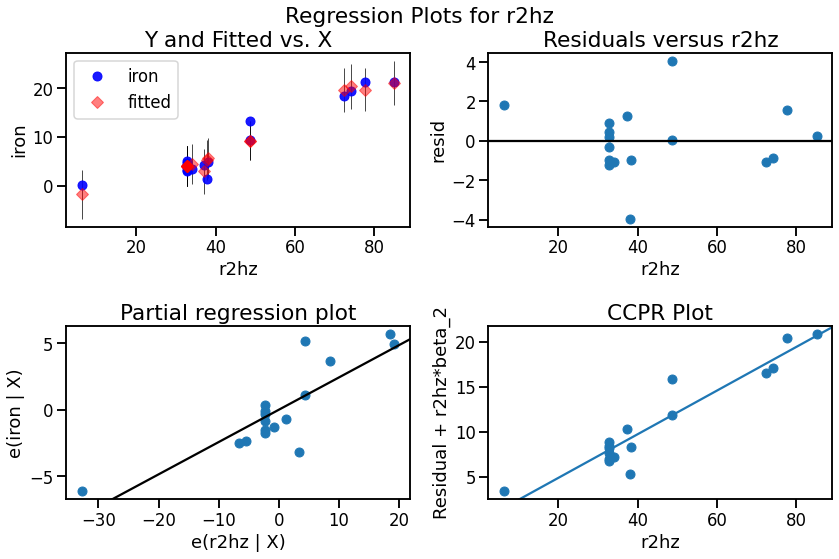

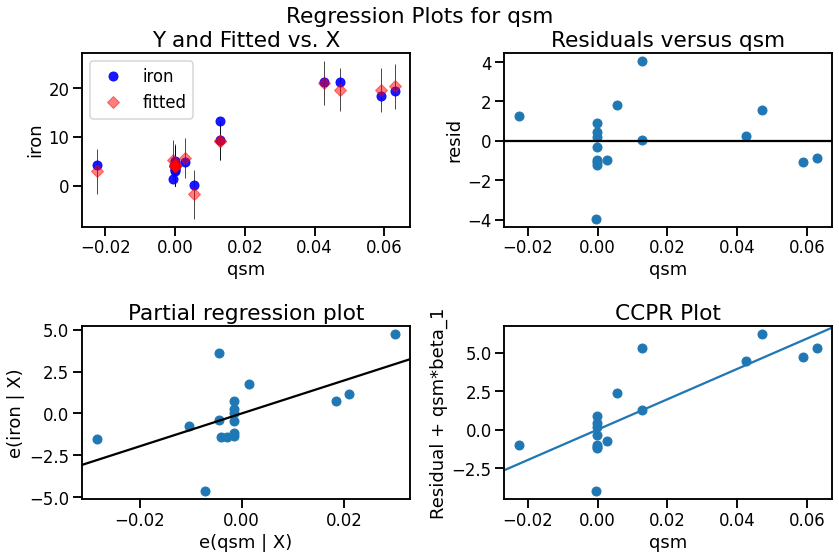

In [186]:
fig = plt.figure(figsize=(12,8))
_ = sm.graphics.plot_regress_exog(model_df.loc[winning_model_idx, 'res'], 'r2hz', fig=fig)

fig = plt.figure(figsize=(12,8))
_ = sm.graphics.plot_regress_exog(model_df.loc[winning_model_idx, 'res'], 'qsm', fig=fig)

the r-squared is:  0.9461236932489062
the coefficient (value of a) for QSM, R2*, constant is:  [98.27947218  0.24310069 -3.82834103]


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  # Remove the CWD from sys.path while we load stuff.


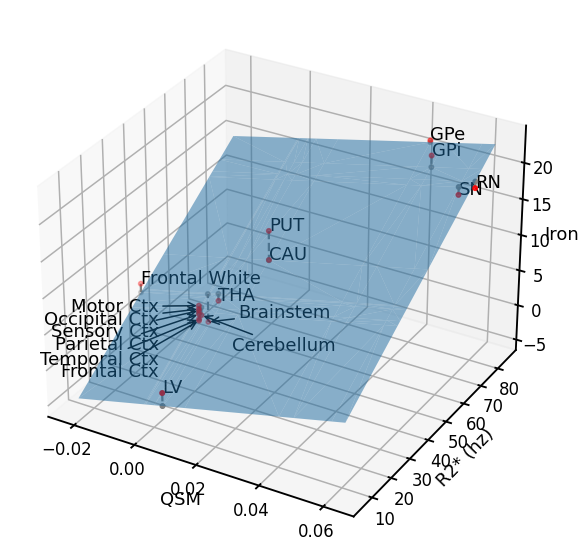

In [187]:
## offsets for annotation texts
xytexts = {
    'Motor Cortex': (-40, -10),
    'Occipital Cortex': (-40, -20),
    'Sensory Cortex': (-40, -30),
    'Parietal Cortex': (-40, -40),
    'Temporal Cortex': (-40, -50),
    'Frontal Cortex': (-40, -60),
    'Cerebellum': (30, -40),
    'Brainstem': (30, 0)
}

X = np.hstack([iron_qmri_combined[['qsm', 'r2hz']].values, np.ones(shape=(iron_qmri_combined.shape[0],1))])
Y = iron_qmri_combined['iron'].values

# Use Linear Algebra to solve
a = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))
predictedY = np.dot(X, a)

# calculate the R-squared
SSres = Y - predictedY
SStot = Y - Y.mean()
rSquared = 1 - (SSres.dot(SSres) / SStot.dot(SStot))
print("the r-squared is: ", rSquared)
print("the coefficient (value of a) for QSM, R2*, constant is: ", a)

# create a wiremesh for the plane that the predicted values will lie
xx, yy, zz = np.meshgrid(X[:, 0], X[:, 1], X[:, 2])
combinedArrays = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
Z = combinedArrays.dot(a)

# graph the original data, predicted data, and wiremesh plane
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], Y, color='r', label='Iron')
ax.scatter(X[:, 0], X[:, 1], predictedY, color='grey')
for i in range(X.shape[0]):
    label = iron_qmri_combined.index[i]
    if 'Cortex' in label: # or 'Cerebellum' in label:
        
        annotate3D(ax, label.replace('Cortex', 'Ctx'), xyz=[X[i,0], X[i,1], Y[i]], xytext=xytexts[label],
                   arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'),  #fontsize=10, xytext=(-3,3),
                   textcoords='offset points', ha='right',va='bottom')
    elif 'Cerebellum' in label or 'Brainstem' in label:
        annotate3D(ax, label.replace('Cortex', 'Ctx'), xyz=[X[i,0], X[i,1], Y[i]], xytext=xytexts[label],
           arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'),  #fontsize=10, xytext=(-3,3),
           textcoords='offset points', ha='left',va='bottom')
    else:
        ax.text(X[i,0], X[i,1], Y[i], label, zorder=1, color='k') 
    
    # plot dashed line to plane
    ax.plot([X[i, 0], X[i, 0]], 
            [X[i, 1], X[i, 1]], 
            [Y[i], predictedY[i]], color='grey', linestyle='dashed')
    
ax.plot_trisurf(combinedArrays[:, 0], combinedArrays[:, 1], Z, alpha=0.5)
ax.set_xlabel('QSM')
ax.set_ylabel('R2* (hz)')
ax.set_zlabel('Iron')

fig.set_size_inches(10,10)

# Model 2: Myelin ~ qMRI
1. Combine myelin estimates with qMRI data.
Note that for the myelin estimates based on the stains, the corresponding qMRI data should be from elderly subjects. Here, we use >= 70 years old

In [188]:
# these structs have estimated myelin from an elderly subject, so take elderly qMRI-values for these ROIs
final_myelin_estimates['myelin'][pd.isnull(final_myelin_estimates['myelin'])].index

Index(['GP', 'PUT', 'RN', 'SN', 'STN', 'GPe', 'GPi'], dtype='object', name='Randall_label')

In [189]:
qmri_for_myelin = data_p30_means.copy()
qmri_for_myelin.loc['GPe'] = data_p70_means.loc['GPe']
qmri_for_myelin.loc['GPi'] = data_p70_means.loc['GPi']
qmri_for_myelin.loc['STR'] = data_p70_means.loc['STR']
qmri_for_myelin.loc['RN'] = data_p70_means.loc['RN']
qmri_for_myelin.loc['SN'] = data_p70_means.loc['SN']
qmri_for_myelin.loc['STN'] = data_p70_means.loc['STN']
qmri_for_myelin.loc['LV', 'r1hz'] =  0.232  # from literature, Metere et al

,qsm,r1hz,r2hz,myelin
ROI,,,,
Brainstem,-0.000486,0.807652,37.959482,15.360000
CAU,0.012768,0.655277,48.644107,6.210000
Frontal Cortex,-0.000004,0.536607,32.722217,5.080000
Frontal White,-0.022469,0.895587,37.179621,16.260000
GPe,0.044293,0.813011,84.874909,10.404170
GPi,0.046384,0.838298,75.215914,10.404170
Parietal Cortex,-0.000004,0.536607,32.722217,5.420000
PUT,0.012768,0.655277,48.644107,5.611496
RN,0.059001,0.894331,72.979113,13.441928


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


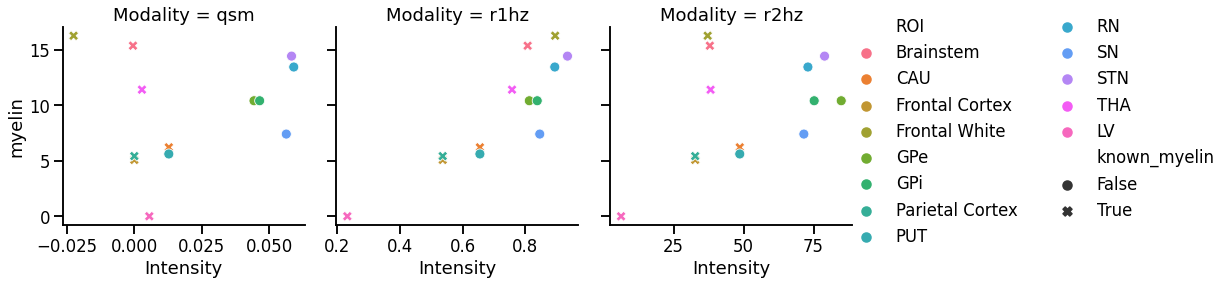

In [190]:
myelin_qmri_combined = pd.merge(qmri_for_myelin, final_myelin_estimates.rename(columns={'final_myelin_concentration_estimate': 'myelin'}).iloc[:,-1], left_index=True, right_index=True)
myelin_qmri_combined.index.name='ROI'
myelin_qmri_combined = myelin_qmri_combined.reindex(['Brainstem', 'CAU', 'Frontal Cortex', 'Frontal White', 'GPe', 'GPi', 'Parietal Cortex', 'PUT', 'RN', 'SN', 'STN', 'THA', 'LV'])
myelin_qmri_combined.round({'qsm': 6, 'r1hz': 3, 'r2hz': 3, 'myelin': 3}).rename(columns={'qsm': 'QSM (ppm)', 'r1hz': 'R1 (Hz)', 'r2hz': 'R2* (Hz)', 'myelin': 'Myelin (ppm)'}).iloc[:,[3,0,1,2]].to_csv('../tables/myelin_qmri_table2.csv', sep='\t') ## table 2 in manuscript

myelin_qmri_combined_melted = myelin_qmri_combined.reset_index().melt(value_vars=['qsm', 'r1hz', 'r2hz'], 
                                                                      id_vars=['ROI', 'myelin'], var_name='Modality', value_name='Intensity')
display(myelin_qmri_combined)
myelin_qmri_combined_melted.head()


# plot relation myelin ~ qMRI
myelin_qmri_combined_melted['known_myelin'] = myelin_qmri_combined_melted.ROI.isin(list(myelin_measures.index))
sns.set_context('talk')
g = sns.relplot("Intensity", "myelin", 
                kind='scatter', col='Modality', hue='ROI', data=myelin_qmri_combined_melted, style="known_myelin", 
                facet_kws={'sharex': False}, s=100, height=4)

handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, ncol=2, loc='center left', 
             bbox_to_anchor=(0.8, 0.5), frameon=False)

## Fit myelin ~ qMRI models

In [191]:
all_models = []
all_res = []
all_X = []

for index, predictors in predictors_binary.iterrows():
#     if index==0:
#         continue
    X = myelin_qmri_combined[['qsm', 'r1hz', 'r2hz']].iloc[:,np.argwhere(predictors.values).ravel()]
    all_X.append(X)
    mod = sm.OLS(myelin_qmri_combined['myelin'], sm.add_constant(X))
    res = mod.fit()
    res.summary()
    
    all_models.append(mod)
    all_res.append(res)
    
model_df = pd.DataFrame({'model': all_models, 'res': all_res})
model_df['params'] = model_df['res'].apply(lambda x: list(x.params.index))
model_df['BIC'] = model_df['res'].apply(lambda x: x.bic)
model_df['AIC'] = model_df['res'].apply(lambda x: x.aic)
model_df['delta_BIC'] = model_df['BIC'] - np.min(model_df['BIC'])
model_df['delta_AIC'] = model_df['AIC'] - np.min(model_df['AIC'])
model_df['rsq'] = model_df['res'].apply(lambda x: x.rsquared)
myelin_model_comparison = model_df.copy()
display(model_df)

winning_model_idx = np.argmin(model_df['BIC'].values)
display(all_res[winning_model_idx].summary())

winning_myelin_model = model_df.loc[winning_model_idx, 'res']

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/home/stevenm/.conda/envs/python3/lib/python3

,model,res,params,BIC,AIC,delta_BIC,delta_AIC,rsq
0,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,[const],79.432355,78.867406,23.774481,24.904380,0.000000
1,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, r2hz]",78.803951,77.674052,23.146077,23.711026,0.217798
2,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, r1hz]",62.629605,61.499706,6.971731,7.536680,0.774587
3,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, r1hz, r2hz]",55.657874,53.963026,0.000000,0.000000,0.891761
4,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, qsm]",81.720663,80.590764,26.062789,26.627738,0.021055
5,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, qsm, r2hz]",77.027583,75.332735,21.369709,21.369709,0.439872
6,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, qsm, r1hz]",58.853471,57.158623,3.195598,3.195598,0.861599
7,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,"[const, qsm, r1hz, r2hz]",58.214733,55.954936,2.556860,1.991910,0.891828


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 myelin   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     41.19
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           1.49e-05
Time:                        10:46:54   Log-Likelihood:                -23.982
No. Observations:                  13   AIC:                             53.96
Df Residuals:                      10   BIC:                             55.66
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.9897      1.978     -4.040      0.002     -12.396      -3.583
r1hz          31.8748      4.039      7.891      0.000      22.874      40.875
r2hz          -0.1118      0.034     -3.290      0.008      -0.188      -0.036
==============================================================================
Omnibus:                        2.454   Durbin-Watson:                   2.767
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                1.158
Skew:                          -0.731   Prob(JB):                        0.560
Kurtosis:                       3.007   Cond. No.                         504.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

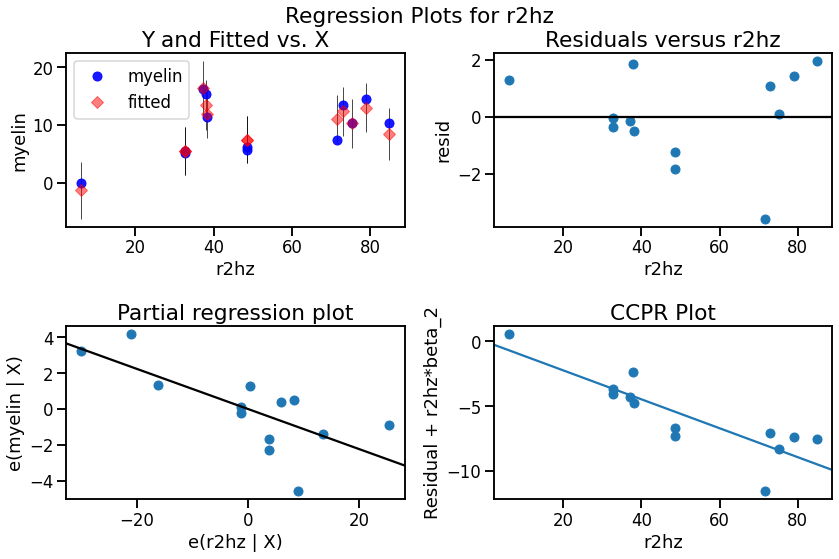

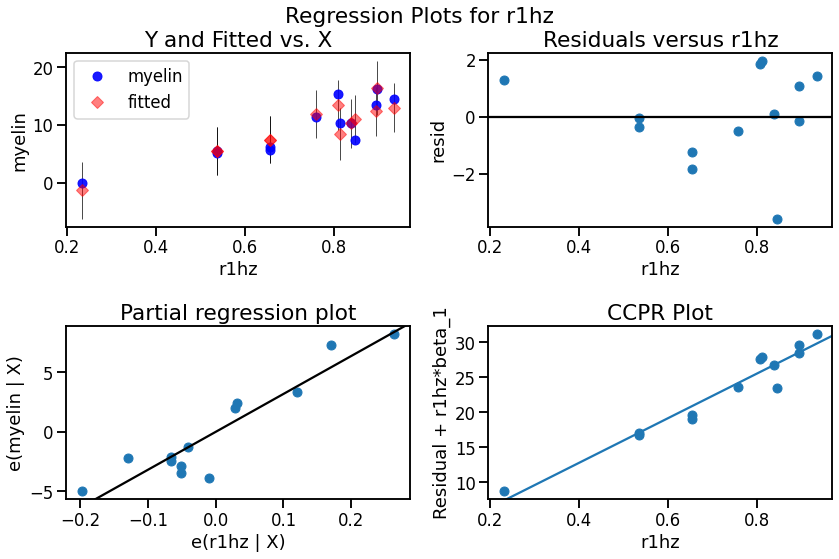

In [192]:
fig = plt.figure(figsize=(12,8))
_ = sm.graphics.plot_regress_exog(model_df.loc[winning_model_idx, 'res'], 'r2hz', fig=fig)

fig = plt.figure(figsize=(12,8))
_ = sm.graphics.plot_regress_exog(model_df.loc[winning_model_idx, 'res'], 'r1hz', fig=fig)

the r-squared is:  0.8917610330012663
the coefficient (value of a) for R1, R2*, constant is:  [31.87483329 -0.11181621 -7.98965042]


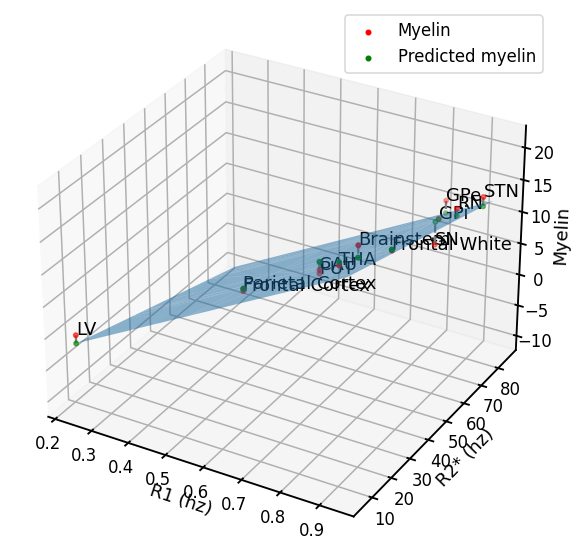

In [193]:
X = np.hstack([myelin_qmri_combined[['r1hz', 'r2hz']].values, np.ones(shape=(myelin_qmri_combined.shape[0],1))])
Y = myelin_qmri_combined['myelin'].values

# Use Linear Algebra to solve
a = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))
predictedY = np.dot(X, a)

# calculate the r-squared
SSres = Y - predictedY
SStot = Y - Y.mean()
rSquared = 1 - (SSres.dot(SSres) / SStot.dot(SStot))
print("the r-squared is: ", rSquared)
print("the coefficient (value of a) for R1, R2*, constant is: ", a)

# create a wiremesh for the plane that the predicted values will lie
xx, yy, zz = np.meshgrid(X[:, 0], X[:, 1], X[:, 2])
combinedArrays = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
Z = combinedArrays.dot(a)

# graph the original data, predicted data, and wiremesh plane
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], Y, color='r', label='Myelin')
ax.scatter(X[:, 0], X[:, 1], predictedY, color='g', label='Predicted myelin')
for i in range(X.shape[0]):
    label = myelin_qmri_combined.index[i]
    ax.text(X[i,0], X[i,1], Y[i], label, zorder=1, color='k') 
    
    # plot dashed line to plane
    ax.plot([X[i, 0], X[i, 0]], 
            [X[i, 1], X[i, 1]], 
            [Y[i], predictedY[i]], color='grey', linestyle='dashed')



ax.plot_trisurf(combinedArrays[:, 0], combinedArrays[:, 1], Z, alpha=0.5)
ax.set_xlabel('R1 (hz)')
ax.set_ylabel('R2* (hz)')
ax.set_zlabel('Myelin')
ax.legend()

fig.set_size_inches(10,10)

## Combined 3D plots

the r-squared is:  0.8917610330012663
the coefficient (value of a) for R1, R2*, constant is:  [31.87483329 -0.11181621 -7.98965042]
the r-squared is:  0.9461236932489062
the coefficient (value of a) for R1, R2*, constant is:  [98.27947218  0.24310069 -3.82834103]


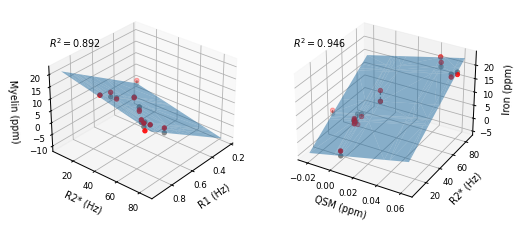

In [194]:
sns.set_context('paper')

annotate = False
fontsize_annotations = 8
fig = plt.figure(2, figsize=(8,4))

for plot_n, outcome_values in enumerate(['myelin', 'iron']):
    if outcome_values == 'myelin':
        combined = myelin_qmri_combined
        predictors = ['r1hz', 'r2hz']
        axes_labels = ['R1 (Hz)', 'R2* (Hz)', 'Myelin (ppm)']
    else:
        combined = iron_qmri_combined
        predictors = ['qsm', 'r2hz']
        axes_labels = ['QSM (ppm)', 'R2* (Hz)', 'Iron (ppm)']
        
    X = np.hstack([combined[predictors].values, np.ones(shape=(combined.shape[0],1))])
    Y = combined[outcome_values].values

    # Use Linear Algebra to solve
    a = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))
    predictedY = np.dot(X, a)

    # calculate the r-squared
    SSres = Y - predictedY
    SStot = Y - Y.mean()
    rSquared = 1 - (SSres.dot(SSres) / SStot.dot(SStot))
    print("the r-squared is: ", rSquared)
    print("the coefficient (value of a) for R1, R2*, constant is: ", a)

    # create a wiremesh for the plane that the predicted values will lie
    xx, yy, zz = np.meshgrid(X[:, 0], X[:, 1], X[:, 2])
    combinedArrays = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
    Z = combinedArrays.dot(a)

    # graph the original data, predicted data, and wiremesh plane
    ax = fig.add_subplot(1,2,plot_n+1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], Y, color='r', label=outcome_values.capitalize())
    ax.scatter(X[:, 0], X[:, 1], predictedY, color='grey')
    for i in range(X.shape[0]):
        if annotate:
            label = combined.index[i]
            if 'Cortex' in label:
                annotate3D(ax, label.replace('Cortex', 'Ctx'), xyz=[X[i,0], X[i,1], Y[i]], xytext=xytexts[label],
                           arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'),  fontsize=fontsize_annotations,
                           textcoords='offset points', ha='right',va='bottom')
            elif 'Cerebellum' in label or 'Brainstem' in label:
                annotate3D(ax, label.replace('Cortex', 'Ctx'), xyz=[X[i,0], X[i,1], Y[i]], xytext=xytexts[label],
                   arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'), fontsize=fontsize_annotations,
                   textcoords='offset points', ha='left',va='bottom')
            else:
                ax.text(X[i,0], X[i,1], Y[i], label, zorder=1, color='k', fontsize=fontsize_annotations) 

        # plot dashed line to plane
        ax.plot([X[i, 0], X[i, 0]], 
                [X[i, 1], X[i, 1]], 
                [Y[i], predictedY[i]], color='grey', linestyle='dashed')

    ax.plot_trisurf(combinedArrays[:, 0], combinedArrays[:, 1], Z, alpha=0.5)
    ax.set_xlabel(axes_labels[0], labelpad=0)
    ax.set_ylabel(axes_labels[1], labelpad=0)
    ax.set_zlabel(axes_labels[2], rotation=90, labelpad=0)
    ax.tick_params(pad=0)
    ax.text2D(0.05, 0.8, f"$R^2 = {rSquared:.3f}$", transform=ax.transAxes)# ax.legend()
    
    if outcome_values == 'myelin':
        ax.view_init(30, 40)

fig.savefig('../figures/original_submission/figure7_3D.pdf', bbox_inches='tight')
fig.savefig('../figures/R1/3D_plane.pdf', bbox_inches='tight')

## Final winning models

In [195]:
print('Iron model:\n iron = {:.6f} + {:.6f}*qsm + {:.6f}*R2s'.format(*winning_iron_model.params))
print('Myelin model:\n myelin = {:.6f} + {:.6f}*R1 + {:.6f}*R2s'.format(*winning_myelin_model.params))

display(winning_iron_model.summary())
display(winning_myelin_model.summary())

Iron model:
 iron = -3.828341 + 98.279472*qsm + 0.243101*R2s
Myelin model:
 myelin = -7.989650 + 31.874833*R1 + -0.111816*R2s


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   iron   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     122.9
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           1.32e-09
Time:                        10:47:33   Log-Likelihood:                -32.819
No. Observations:                  17   AIC:                             71.64
Df Residuals:                      14   BIC:                             74.14
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8283      1.523     -2.514      0.025      -7.094      -0.563
qsm           98.2795     35.202      2.792      0.014      22.779     173.780
r2hz           0.2431      0.041      5.931      0.000       0.155       0.331
==============================================================================
Omnibus:                        2.880   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                0.992
Skew:                           0.145   Prob(JB):                        0.609
Kurtosis:                       4.148   Cond. No.                     3.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 myelin   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     41.19
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           1.49e-05
Time:                        10:47:33   Log-Likelihood:                -23.982
No. Observations:                  13   AIC:                             53.96
Df Residuals:                      10   BIC:                             55.66
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.9897      1.978     -4.040      0.002     -12.396      -3.583
r1hz          31.8748      4.039      7.891      0.000      22.874      40.875
r2hz          -0.1118      0.034     -3.290      0.008      -0.188      -0.036
==============================================================================
Omnibus:                        2.454   Durbin-Watson:                   2.767
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                1.158
Skew:                          -0.731   Prob(JB):                        0.560
Kurtosis:                       3.007   Cond. No.                         504.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Reviewer 3: Add model comparisons of myelin / iron models

In [196]:
def get_param_value(x, par_name):
    if par_name in x.index:
        return x[par_name]
    else:
        return '-'

In [197]:
myelin_model_comparison['intercept'] = myelin_model_comparison['res'].apply(lambda x: get_param_value(x.params, 'const'))
myelin_model_comparison['R1'] = myelin_model_comparison['res'].apply(lambda x: get_param_value(x.params, 'r1hz'))
myelin_model_comparison['R2*'] = myelin_model_comparison['res'].apply(lambda x: get_param_value(x.params, 'r2hz'))
myelin_model_comparison['QSM'] = myelin_model_comparison['res'].apply(lambda x: get_param_value(x.params, 'qsm'))

myelin_model_comparison[['params', 'intercept', 'R1', 'R2*', 'QSM', 'rsq', 'BIC', 'AIC']]#

#myelin_model_comparison['params']

,params,intercept,R1,R2*,QSM,rsq,BIC,AIC
0,[const],9.340130,-,-,-,0.000000,79.432355,78.867406
1,"[const, r2hz]",4.412269,-,0.0962063,-,0.217798,78.803951,77.674052
2,"[const, r1hz]",-6.259360,21.5651,-,-,0.774587,62.629605,61.499706
3,"[const, r1hz, r2hz]",-7.989650,31.8748,-0.111816,-,0.891761,55.657874,53.963026
4,"[const, qsm]",8.802935,-,-,25.3892,0.021055,81.720663,80.590764
5,"[const, qsm, r2hz]",-0.240576,-,0.251167,-155.236,0.439872,77.027583,75.332735
6,"[const, qsm, r1hz]",-7.752295,25.3313,-,-58.1993,0.861599,58.853471,57.158623
7,"[const, qsm, r1hz, r2hz]",-7.978760,32.1029,-0.116624,3.32451,0.891828,58.214733,55.954936


In [198]:
iron_model_comparison['intercept'] = iron_model_comparison['res'].apply(lambda x: get_param_value(x.params, 'const'))
iron_model_comparison['R1'] = iron_model_comparison['res'].apply(lambda x: get_param_value(x.params, 'r1hz'))
iron_model_comparison['R2*'] = iron_model_comparison['res'].apply(lambda x: get_param_value(x.params, 'r2hz'))
iron_model_comparison['QSM'] = iron_model_comparison['res'].apply(lambda x: get_param_value(x.params, 'qsm'))

iron_model_comparison[['params', 'intercept', 'R1', 'R2*', 'QSM', 'rsq', 'BIC', 'AIC']]#

,params,intercept,R1,R2*,QSM,rsq,BIC,AIC
0,[const],8.277176,-,-,-,0.000000,118.128451,117.295238
1,"[const, r2hz]",-6.835762,-,0.339622,-,0.916128,78.827816,77.161389
2,"[const, r1hz]",-11.253757,29.2822,-,-,0.481131,109.807897,108.141471
3,"[const, r1hz, r2hz]",-3.454363,-9.2427,0.402172,-,0.932988,77.845780,75.346140
4,"[const, qsm]",4.681679,-,-,274.41,0.810731,92.663665,90.997238
5,"[const, qsm, r2hz]",-3.828341,-,0.243101,98.2795,0.946124,74.136782,71.637142
6,"[const, qsm, r1hz]",-2.591472,11.8357,-,227.002,0.865138,89.735354,87.235714
7,"[const, qsm, r1hz, r2hz]",-2.413865,-5.22683,0.294447,82.014,0.950694,75.463011,72.130158


In [199]:
def format_model_str(x):
    par_names = x.index #all_models[['intercept', 'R1', 'R2*', 'QSM']].iloc[0].index
    par_vals = x.values #all_models[['intercept', 'R1', 'R2*', 'QSM']].iloc[0].values
    
    model_str = 'y = ' + str(np.round(par_vals[0], 5))
    for name, val in zip(par_names[1:], par_vals[1:]):
        if not val == '-':
            if val > 0:
                model_str += ' + '
            else:
                model_str += ' '
            model_str += str(np.round(val, 5)) + 'x' + name
            
    return model_str


In [200]:
all_models = pd.concat([iron_model_comparison, myelin_model_comparison])[['params', 'intercept', 'R1', 'R2*', 'QSM', 'rsq', 'BIC', 'AIC']]#
all_models['Predictors'] = all_models['params'].apply(lambda x: ', '.join(x).replace('const', 'Intercept').replace('r2hz', 'R2*').replace('r1hz', 'R1').replace('qsm', 'QSM'))

all_models['parameterized_model'] = all_models[['intercept', 'R1', 'R2*', 'QSM']].apply(lambda x: format_model_str(x), axis=1)
all_models = all_models[['Predictors', 'parameterized_model', 'rsq', 'AIC', 'BIC']]
all_models = all_models.rename(columns={'parameterized_model': 'Parameterized model', 'rsq': 'R^2'})

all_models[['R^2', 'AIC', 'BIC']] = all_models[['R^2', 'AIC', 'BIC']].round(4)#[[]]
all_models.to_csv('./iron_myelin_model_comparison.csv', sep='\t')     # for paper
#

In [201]:
all_models

,Predictors,Parameterized model,R^2,AIC,BIC
0,Intercept,y = 8.27718,0.0000,117.2952,118.1285
1,"Intercept, R2*",y = -6.83576 + 0.33962xR2*,0.9161,77.1614,78.8278
2,"Intercept, R1",y = -11.25376 + 29.28218xR1,0.4811,108.1415,109.8079
3,"Intercept, R1, R2*",y = -3.45436 -9.2427xR1 + 0.40217xR2*,0.9330,75.3461,77.8458
4,"Intercept, QSM",y = 4.68168 + 274.40993xQSM,0.8107,90.9972,92.6637
5,"Intercept, QSM, R2*",y = -3.82834 + 0.2431xR2* + 98.27947xQSM,0.9461,71.6371,74.1368
6,"Intercept, QSM, R1",y = -2.59147 + 11.83574xR1 + 227.0019xQSM,0.8651,87.2357,89.7354
7,"Intercept, QSM, R1, R2*",y = -2.41386 -5.22683xR1 + 0.29445xR2* + 82.01...,0.9507,72.1302,75.4630
0,Intercept,y = 9.34013,0.0000,78.8674,79.4324
1,"Intercept, R2*",y = 4.41227 + 0.09621xR2*,0.2178,77.6741,78.8040
